# Homework 8

## Problem 1

This problem is a walking through the 1d finite element method for the Helmholtz equation (which is a "hello world" equation in FEM!). 

**Step one: Weak form**

Starting from
$$
\int_{0}^{1}\varphi\biggl(\frac{d^2 u}{d x^2}+k^2u\bigg)\,dx = -\int_{0}^{1}\varphi\sin(\pi x)\,dx
$$
Integration by parts gives$$
\int_{0}^{1}\biggl(\varphi'u'-k^2\varphi u\bigg)\,dx = 
\int_{0}^{1}\varphi\sin(\pi x)\,dx
$$

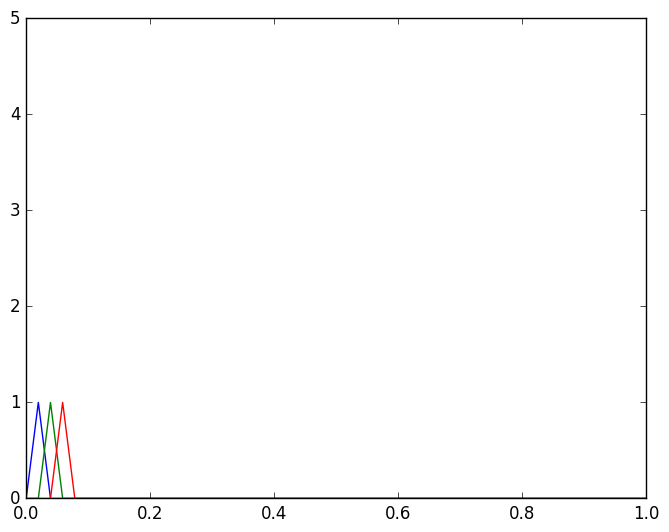

4-element Array{Int64,1}:
 0
 1
 0
 5

In [9]:
# This is a plot of the first 3 shape functions
using PyPlot
x = linspace(0, 1, 52)
phi1 = zeros(size(x))
phi1[2] = 1
phi2 = zeros(size(x))
phi2[3] = 1
phi3 = zeros(size(x))
phi3[4] = 1
plot(x, phi1, color = "blue")
plot(x, phi2, color = "green")
plot(x, phi3, color = "red")
axis([0,1,0,5])

** Step two: Meshing, turn into algebraic form and assemble the stiffness matrix**

In 1d, the meshing is simply a discritization of the interval $[0,1]$. For simplicity, I only consider grids of uniform size, so as to divide the interval into $N$ segments:
$$
0=x_0<x_1=\frac{1}{N+1}<x_2=\frac{2}{N+1}<\cdots<x_{N+1}=1
$$
The reason for me to do this is because the calculations only involve non-boundary points, and I want to incorporate boundary conditions later. **Notice that I am doing slightly different from class here, where BC's are incorporated into the assembly matrix, but the results are the same as one can easily deduce.** 

In each small element which is the interval $[x_j,x_{j+1}],(j=1,\cdots,N)$, we interpolate the unknown funcion $u$ as
$$
u=u_j\varphi_j+u_{j+1}\varphi_{j+1}
$$
where $\varphi_j$'s are the shape functions defined as
$$
\varphi_j(x) = \frac{x-x_{j+1}}{x_{j}-x_{j+1}}
$$
and$$
\varphi_{j+1}(x) = \frac{x-x_{j}}{x_{j+1}-x_j}
$$
Inserting the interpolation equation into the weak form, we have locally (in the interval $[t_j,t_{j+1}]$):
$$
\int_0^1\sum_{l=j}^{j+1}\biggl(\varphi_i'\varphi_l'-k^2\varphi_i\varphi_l\biggr)u_l\,dx = \int_0^1\varphi_i\sin(\pi x)\,dx   
$$

It becomes easier to understand if we sum up the above small elements and write it into a matrix form
$$
\bf{M}\cdot\bf{u} = RHS
$$
where$$
\bf{M}_{ij} = \int_0^1\biggl(\varphi_i'\varphi_j'-k^2\varphi_i\varphi_j\biggr)\,dx
$$
Denote by $\bf{K}_{ij} = \int_0^1\varphi_i'\varphi_j'\,dx$ and $\bf{B}_{ij} = \int_0^1\varphi_i\varphi_j\,dx$. $$
\bf{M}_{ij} = \bf{K}_{ij} - k^2\bf{B}_{ij}
$$

Considering the support of each shape function, for each $i$, only the nodes $i-1$, $i$, $i+1$ will come into the above equation. It suffices for us to calculate the following integrals:
$$
\int_0^1\varphi_j'\varphi_j'\,dx
$$
$$
\int_0^1\varphi_j\varphi_j\,dx
$$
$$
\int_0^1\varphi_j'\varphi_{j+1}'\,dx
$$
$$
\int_0^1\varphi_j\varphi_{j+1}\,dx 
$$

After calculation, I got
$$
\int_0^1\varphi_j'\varphi_j'\,dx = 2(N+1), \int_0^1\varphi_j'\varphi_{j+1}'\,dx= -(N+1) 
$$
and$$
\int_0^1\varphi_j\varphi_j\,dx = \frac{2}{3(N+1)}, \int_0^1\varphi_j\varphi_{j+1}\,dx = \frac{1}{6(N+1)}
$$


This tells you how to build up the global stiffness matrix. It is tri-diagonal, with $-1$ diagonal given by $-(N+1)-\frac{k^2}{6(N+1)}$, diagonal given by $2(N+1)-\frac{2k^2}{3(N+1)}$, and $+1$ diagonal given by $-(N+1)-\frac{k^2}{6(N+1)}$.

The loading vector is also straightforward to calculate. As in class, we expressed $\sin(\pi x)$ by
$$
\sin(\pi x) = \sum_j\sin(\pi x_j)\varphi_j(x)
$$
so that$$
\int_0^1\sin(\pi x)\varphi_j(x)\,dx=\sum_{i}\int_0^1\varphi_j(x)\cdot\varphi_i(x)\sin(\pi x_i)\,dx=\bf{B}\cdot\bf{f}
$$
where $\bf{f}$ is simply the sample of $f=\sin(\pi x)$.

I also got the analytical way of doing this by
$$
\int_0^1\varphi_{j+1}\sin(\pi x)\,dx=\frac{N+1}{\pi^2}[-\sin(\pi x_{j+2})-\sin(\pi x_j)+2\sin(\pi x_{j+1})]
$$

In [58]:
# This is the code for solving 1d Helmholtz equation in Problem 1, HW8
# N is the total number of interior points
# k is the wave number
################################################
using PyPlot
function fem_1dHelmholtz(N, k)
# Firstly assembling the global stiffness matrix
x = linspace(0, 1, N+2)
data1 = (-(N+1)*ones(N-1), 2*(N+1)*ones(N), -(N+1)*ones(N-1))
data2 = (k^2*ones(N-1)/6/(N+1), k^2*4*ones(N)/6/(N+1), k^2*ones(N-1)/6/(N+1))
diags = (-1, 0, 1)
K1 = spdiagm(data1, diags, N, N)
K2 = spdiagm(data2, diags, N, N)
K = K1-K2
# Now allocate the load vector
F = zeros(N)
for j = 0:N-1
    F[j+1] = (N+1)/(pi*pi)*(-sin(pi*x[j+3])-sin(pi*x[j+1])+2*sin(pi*x[j+2]))
end
# Linear solver
u = K\F
# Plot the result based on the meshing; incorporate the boundary
u = [0; u; 0]
end

fem_1dHelmholtz (generic function with 1 method)

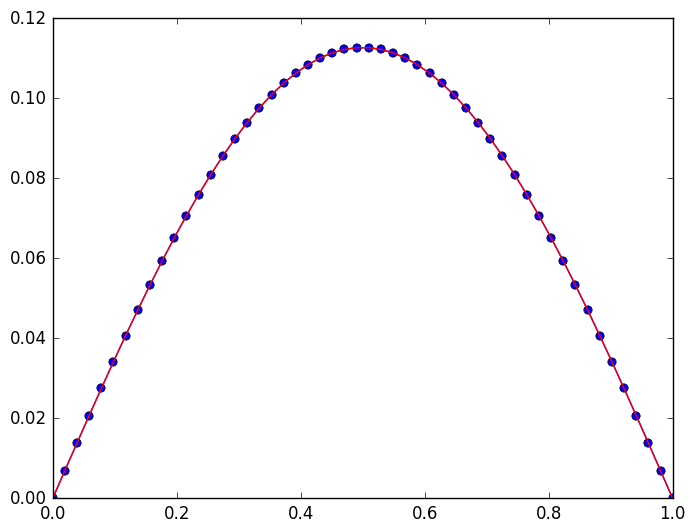

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000027DCE8D0>

In [62]:
using PyPlot
N = 50
k = 1
x = linspace(0, 1, N+2)
u = fem_1dHelmholtz(N, k)
u_true = 1/(pi^2-k^2)*sin(pi*x)
plot(x, u, color = "blue", marker = "o")
plot(x, u_true, color = "red")

In [66]:
u_sol(t) = 1/(pi^2-k^2)*sin(pi*t)

u_sol (generic function with 1 method)

In [67]:
function rms_error(N,k)
    xx = linspace(0, 1, N+2)
    u = fem_1dHelmholtz(N, k)
    rms_error = norm(u-u_sol(xx))/(N+1)
end

rms_error (generic function with 2 methods)

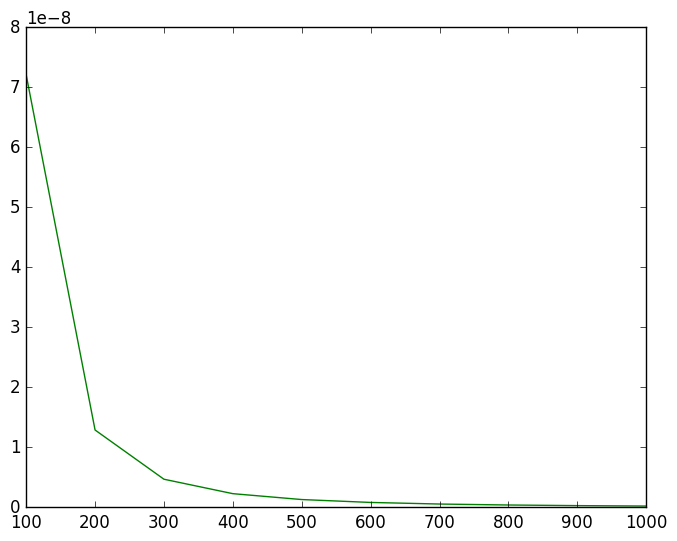

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000027FA1748>

In [82]:
N = 100:100:1000
r = zeros(size(N))
for i = 1:length(r)
    r[i] = rms_error(N[i], 1)
end
plot(N, r, color = "green")

## Probelm 2

This problem requires you to get yourself familiar with the MATLAB PDE Toolbox -- Not only how to handle it as a "toy", but also how to use command lines. I strongly recommend you to take a look at the examples in <https://www.mathworks.com/help/pde/ug/visualize-2d-solutions-and-gradients.html>. Also you should read the [PDE Toolbox documentation](http://www.mathworks.com/help/pde/functionlist.html?s_cid=doc_ftr).

In the first part codes,  
```
model = createpde;
geometryFromEdges(model,@lshapeg);
applyBoundaryCondition(model,'dirichlet','edge',1:model.Geometry.NumEdges,'u',0);
c = 1;
a = 0;
f = 1;
specifyCoefficients(model,'m',0,'d',0,'c',c,'a',a,'f',f);
generateMesh(model);
results = solvepde(model);
```
You need to persuade yourself what each line means by looking at the PDE Toolbox decumentation. I will just walk you through part of them. 

``model = createpde;`` means we create a PDE model (literally!). It is a PDEModel **object** if you are familar with 

``geometryFromEdges(model,@lshapeg);`` creates the 2D geometry. ``@lshapeg``is the function handle thar decribes the geometry. Please look up in the document to see what function handle you wanna use (sometimes you need to create by yourself!)

``applyBoundaryCondition(model,'dirichlet','edge',1:model.Geometry.NumEdges,'u',0);`` returns the boundary conditions. pay attention to the ``1:model.Geometry.NumEdges`` part, this is the **Region ID**. In our case you have to split this into two parts, $(1:2)$ and $(3:4)$ with $100$ and $0$ respectively.

After you finish the above procedure, you will be able to obtain your ``results``. This is nothing but the **real results**. My next suggestion would be for you to interpolate using the following code:
```
v = linspace(-1,1,101);
[X,Y] = meshgrid(v);
querypoints = [X(:),Y(:)]';
uintrp = interpolateSolution(results,querypoints);
```
It is fairly straightforward to read. 